In [1]:
%load_ext autoreload
%autoreload 2

from dlp.dataset import Dataset
from dlp.visualizer import SemanticVisualizer
from IPython.display import display
from pathlib import Path

from spot_detector.detector import LocalDetector
import matplotlib.pyplot as plt
import cv2

import numpy as np

## Load Dataset

In [2]:
# Load dataset
ds = Dataset()

home_path = str(Path.home())
ds.load(home_path + '/dlp-dataset/data/DJI_0012')

## Plot the local view

In [3]:
# Instantiate the visualizer object
smt_vis = SemanticVisualizer(ds, steps=10)

scene = ds.get('scene', ds.list_scenes()[0])
frame = ds.get_future_frames(scene['first_frame'],timesteps=50)[-1]
# frame = ds.get('frame', scene['first_frame'])
img_frame = smt_vis.plot_frame(frame['frame_token'])

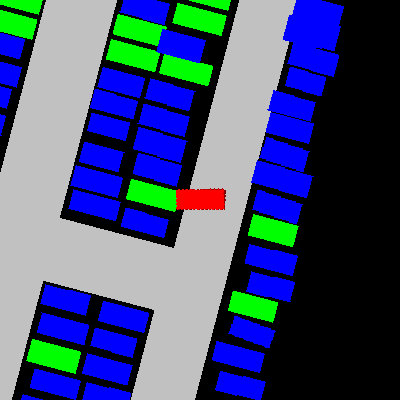

In [4]:
img = smt_vis.inst_centric(img_frame, frame['instances'][0])
display(img)

## Spot Detector

In [5]:
spot_color_rgb = (0, 255, 0)

detector = LocalDetector(spot_color_rgb)

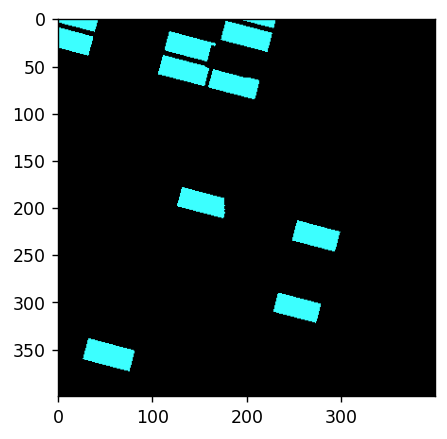

In [6]:
res = detector.spots_mask(img)
plt.imshow(res)

In [7]:
boxes = detector.detect(img)
result_img = res.copy()

for rect in boxes:
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(result_img,[box],0,(255,0,0),2)

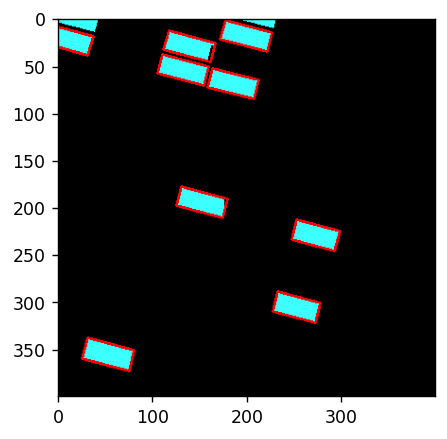

In [8]:
plt.imshow(result_img)